In [1]:
!pip install openai

In [10]:
import json
import openai
import random
random.seed(30)
from gpt import GPT
from gpt import Example
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def change_labels(num):
    if num == 1:
        return "positive"
    elif num == 0:
        return "neutral"
    elif num == -1:
        return "negative"

In [4]:
def transform_txt(filename, n): # n is the number of randomly chosen input instances wanted for each sentiment category
    """
    This function reads input sentences and associated sentiments 
    """
    # reading text filename into a Dataframe
    all_data = pd.read_csv(filename, header = 0, encoding = "utf8", sep = ":->")
    all_data['Sentiment_class_label'] = all_data['Sentiment_class_label'].apply(lambda x: change_labels(x))
    df_used = all_data.groupby('Sentiment_class_label').apply(lambda x: x.sample(n)).reset_index(drop=True)
    #df_used = data.groupby('Sentiment_class_label', as_index = False).apply(fn)
    return all_data, df_used
    

In [5]:
def extract_example_df(all_data, n):
    df_subset = all_data.groupby('Sentiment_class_label').apply(lambda x: x.sample(n)).reset_index(drop = True)
    return df_subset

In [6]:
def add_examples(gpt_instance, df_subset): # n is the number of Example instances to "train" GPT-3 on
    for row in range(df_subset.shape[0]):
        gpt_instance.add_example(Example(df_subset['Phrase_text'][row], df_subset['Sentiment_class_label'][row]))
    return gpt_instance

In [7]:
# A function to write prompt into GPT-3 API:
def write_prompts(df_used, gpt_instance):
    df_used['gpt_output'] = df_used["Phrase_text"].apply(lambda x: gpt_instance.submit_request(x).choices[0].text.replace("output (positive/neutral/negative):", "").strip("\n"))
    df_used['matched'] = np.where(df_used['Sentiment_class_label'] == df_used['gpt_output'], 1, 0)
    # dropping Sentiment_class_label column
    #df_used.drop(['Sentiment_class_label'], axis = 1)
    return df_used


In [8]:
# Function to write the accuracy at the beginning of output text file
def line_prepender(filename, line):
    with open(filename, encoding = "utf8", mode='r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n') + '\n' + content)




In [9]:
with open('GPT_SECRET_KEY.json') as f:
    data = json.load(f)
openai.api_key = data["API_KEY"]
temp_list = [0.0, 0.5, 1.0]
accuracy_list = []
all_data, df_used = transform_txt("sm_text_sentiment_training.txt", 4)
real_df_used = df_used.copy()
df_subset = extract_example_df(all_data, 1)
for temp in temp_list:
    gpt = GPT(engine = "davinci", temperature = temp, max_tokens = 100, output_prefix = "output (positive/neutral/negative):")
    gpt = add_examples(gpt, df_subset)
    out_df = write_prompts(df_used, gpt)
    out_df.drop("Sentiment_class_label", axis = 1, inplace = True)
    accuracy = ((np.sum(out_df['matched'])) / (out_df.shape[0])) * 100
    accuracy_list.append(round(accuracy))
    out_df.to_csv('outf{}.txt'.format(temp), header = ['Phrase_text', 'gpt_output', 'matched'], index = None, sep = " ", mode = 'a')
    line_prepender('outf{}.txt'.format(temp), "accuracy: {:.2f}".format(accuracy))
    line_prepender('outf{}.txt'.format(temp), str(temp))
    df_used = real_df_used.copy()

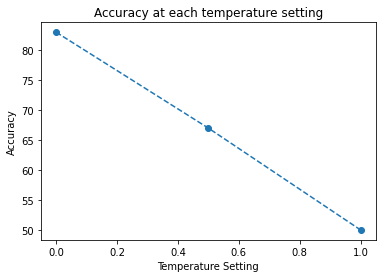

In [22]:
# Visualisation of temperature setting vs accuracy:
accuracy_list = [83, 67, 50]
plt.plot(temp_list, accuracy_list, linestyle = "--", marker = "o")
plt.xlabel("Temperature Setting")
plt.ylabel("Accuracy")
plt.title("Accuracy at each temperature setting")
plt.show()